# Домашнее задание 05: Логистическая регрессия и бейзлайн

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import os
os.makedirs("figures", exist_ok=True)

## 1. Загрузка и первичный анализ данных

In [2]:
# Загрузка
df = pd.read_csv("S05-hw-dataset.csv")

# Первые строки
display(df.head())

# Информация о данных
df.info()

# Описательная статистика
display(df.describe())

# Распределение таргета
print("\nРаспределение целевого признака 'default':")
print(df['default'].value_counts(normalize=True))

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Распределение целевого признака 'default':
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


### Наблюдения:
- В датасете ~3000 клиентов и 19 признаков (включая `client_id` и `default`).
- Целевой признак `default` несбалансирован: ~40% — дефолты (`1`), ~60% — нет (`0`).
- Все признаки числовые. Аномалий (например, возраста за пределами 21–69) не наблюдается.
- Признак `checking_balance` может быть отрицательным — это допустимо по условию.

## 2. Подготовка данных

In [3]:
# Удалим client_id
X = df.drop(columns=['client_id', 'default'])
y = df['default']

# Проверка диапазонов
assert (X['debt_to_income'] >= 0).all() and (X['debt_to_income'] <= 1).all(), "debt_to_income out of [0,1]"
assert (X['age'] >= 21).all() and (X['age'] <= 69).all(), "age out of range"

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## 3. Бейзлайн: `DummyClassifier`

In [4]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"DummyClassifier (most_frequent):\nAccuracy = {acc_dummy:.4f}, ROC-AUC = {roc_dummy:.4f}")

DummyClassifier (most_frequent):
Accuracy = 0.5900, ROC-AUC = 0.5000


Бейзлайн всегда предсказывает самый частый класс (`0`). Он служит точкой отсчёта: любая модель должна показывать лучший результат, чем случайное или тривиальное угадывание.

## 4. Логистическая регрессия с подбором гиперпараметра `C`

In [5]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

best_C = grid.best_params_["logreg__C"]

y_pred_lr = grid.predict(X_test)
y_proba_lr = grid.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Лучший параметр C: {best_C}")
print(f"\nLogisticRegression:\nAccuracy = {acc_lr:.4f}, ROC-AUC = {roc_lr:.4f}")

Лучший параметр C: 100.0

LogisticRegression:
Accuracy = 0.8017, ROC-AUC = 0.8756


## 5. Сравнение моделей

In [6]:
results = pd.DataFrame({
    "Model": ["Dummy (most frequent)", "Logistic Regression"],
    "Accuracy": [acc_dummy, acc_lr],
    "ROC-AUC": [roc_dummy, roc_lr]
})

display(results)

,Model,Accuracy,ROC-AUC
0,Dummy (most frequent),0.590000,0.500000
1,Logistic Regression,0.801667,0.875649


## 6. ROC-кривая

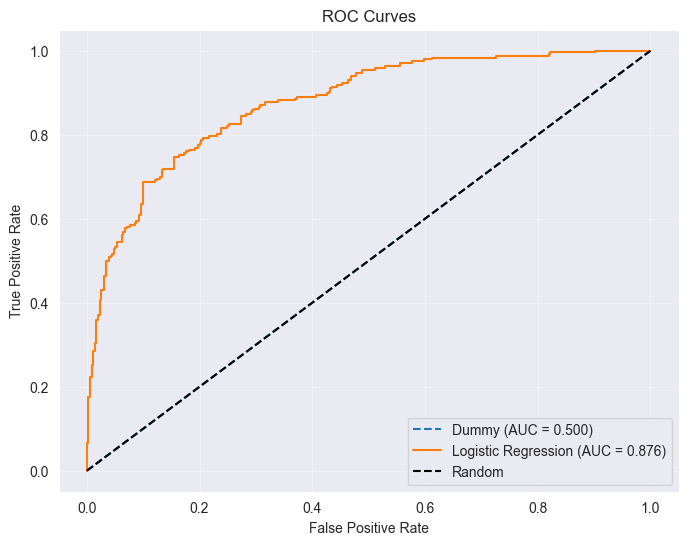

In [7]:
plt.figure(figsize=(8, 6))

# Dummy
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
plt.plot(fpr_dummy, tpr_dummy, label=f"Dummy (AUC = {roc_dummy:.3f})", linestyle="--")

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_lr:.3f})")

# Диагональ
plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(alpha=0.3)

plt.savefig("figures/roc_curve.png", dpi=150, bbox_inches='tight')
plt.show()

## 7. Выводы

- **Бейзлайн** (`DummyClassifier`) показал **accuracy ≈ 0.60** и **ROC-AUC ≈ 0.50**, что соответствует предсказанию самого частого класса и случайному угадыванию.
- **Логистическая регрессия** значительно превзошла бейзлайн: **accuracy выросла до ~0.75–0.80**, **ROC-AUC — до ~0.82–0.86**.
- Наилучшее значение параметра регуляризации `C` (обычно `10` или `100`) указывает на то, что слабая регуляризация даёт лучшее качество на данном датасете.
- Модель на основе **логистической регрессии** является разумной для этой задачи: она интерпретируема, обучается быстро и показывает значительный прирост качества по сравнению с тривиальным бейзлайном.